# Información de hardware
https://colab.research.google.com/notebooks/pro.ipynb?authuser=2#scrollTo=23TOba33L4qf

In [1]:
import warnings
warnings.filterwarnings("ignore")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 26 20:29:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


### Conectado a Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# !pip install pip-chill
# !pip-chill

### Librerias

In [5]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import math
import keras.callbacks
from keras.layers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from keras import backend as k
from keras import optimizers
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

### Variables globales - (Guardar resultados)

In [6]:
gb_dataset_type  = 'Fundus'
gb_dataset_name  = 'RIM'

gb_datasets_dir  = os.path.join('/content/drive/MyDrive/Colab Notebooks/DataSets', gb_dataset_type, gb_dataset_name)
gb_result_dir    = os.path.join('/content/drive/MyDrive/Colab Notebooks/ResultadosEntrenamiento', gb_dataset_type, gb_dataset_name)

gb_nb_clases  = 2

### Graficar precisión y perdidas

In [7]:
def plot_loss_accurancy(history, write_path):
  #Valores a graficar
  acc      = history.history['accuracy']
  val_acc  = history.history['val_accuracy']
  loss     = history.history['loss']
  val_loss = history.history['val_loss']

  #Definir gráficos
  plt.figure(1)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Validation'], loc='upper left')
  fig_accu =  plt.figure(1)

  plt.figure(2)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model Losses')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['Train', 'Validation'], loc='upper left')
  fig_loss =  plt.figure(2)
  plt.show()

  #Guardar gráficos
  fig_accu.savefig(os.path.join(gb_result_dir, write_path + 'accu.png'))
  fig_loss.savefig(os.path.join(gb_result_dir, write_path + 'loss.png'))

  #Guardar datos de entrenamiento
  df_a = pd.DataFrame(acc, columns = ['accuracy'])
  df_b = pd.DataFrame(val_acc, columns = ['val_accuracy'])
  df_c = pd.DataFrame(loss, columns = ['loss'])
  df_d = pd.DataFrame(val_loss, columns = ['val_loss'])

  frames = [df_a,df_b,df_c,df_d]
  df = pd.concat(frames, axis=1)

  df.to_csv(os.path.join(gb_result_dir, write_path + 'History.csv'), index=False)

  print('Datos entrenamiento y Gráficos guardados!!!\n')

### Guardar resultados modelo y pesos

In [8]:
def save_model_weigths(model,write_path):
  #Save model
  # model_json = model.to_json()
  # with open(os.path.join(gb_result_dir, write_path + 'model.json'), "w") as json_file:
  #     json_file.write(model_json)

  #Save weigths
  # model.save(os.path.join(gb_result_dir, write_path + 'weigths.h5'))

  print('\nModelo y pesos guardados!!!\n')

### Guardar resultados de valid-test

In [9]:
def save_results(stats, write_path):
  df_a = pd.DataFrame(stats[0][0], columns=['Filenames'])
  df_b = pd.DataFrame(stats[0][1], columns=['classes'])
  df_c = pd.DataFrame(stats[0][2], columns=['prob_clase_1','prob_clase_2'])
  df_d = pd.DataFrame(stats[0][3], columns=['pred'])

  frames = [df_a,df_b,df_c,df_d]

  df = pd.concat(frames, axis=1)
  df.to_csv(write_path, index=False)

  flg_message = False if 'ValidPredicts.csv' in write_path else True

  if flg_message:
    print('Test.csv guardado!!!')

### Dimensiones

In [10]:
def getImageDims(model):
    if model == 'VGG16' or model == 'VGG19' or model == 'InceptionResNetV2':
        width, height = 224, 224

    elif model == 'ResNet50' or model == 'ResNet101' or model == 'ResNet50V2':
        width, height = 224, 224

    elif model == 'DenseNet121' or model == 'DenseNet169':
        width, height = 224, 224

    elif model == 'InceptionV3' or model == 'Xception':
        width, height = 299, 299

    elif model == 'NASNetLarge':
        width, height = 331, 331

    elif model == 'MobileNet' or model == 'MobileNetV2' or model == 'NASNetMobile':
        width, height = 224, 224

    return width, height

### Fine tuning class


In [11]:
# fix seed for reproducible results (only works on CPU, not GPU)
seed = 101
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [12]:
class CNN_classifier_generator(object):
    def __init__(self, classifier_name, numEpochs, batch_size,learning_rate, top_model,based_model_last_block_layer_number, train_dir,
                 valid_dir, test_dir,nomenclature):

        # hyper parameters for model
        self.modelNameResults = classifier_name # Classifier name
        self.based_model_last_block_layer_number = based_model_last_block_layer_number   # value is based on based model selected
        self.img_width, self.img_height = getImageDims(self.modelNameResults)  # change based on the architecture
        self.batch_size = batch_size  # powers of 2 values
        self.numEpochs = numEpochs
        self.nb_classes = gb_nb_clases  #3    # number of classes
        self.learn_rate = learning_rate #1e-4 # sgd learning rate
        self.momentum = .9  # sgd momentum to avoid local minimum
        self.transformation_ratio = .2  # how aggressive will be the data augmentation/transformation

        print('------------ lr: '+ str(self.learn_rate) + ' - batch_size: ' + str(self.batch_size) + '------------')

        # Paths
        #self.model_name = 'model.json'
        #self.model_weights = 'weights.h5'
        #self.model_path = model_path
        #self.results_dir = results_dir
        self.train_dir = train_dir
        self.valid_dir = valid_dir
        self.test_dir = test_dir
        self.top_model = top_model
        self.nomenclature = nomenclature

        # Creating model

        # Pre-Trained CNN Model using imagenet dataset for pre-trained weights
        base_model = globals()[self.modelNameResults](input_shape=(self.img_width, self.img_height, 3), weights='imagenet', include_top=False)

        # Top Model Block
        if self.top_model == 1:
            x = base_model.output
            x = GlobalAveragePooling2D()(x)
            predictions = Dense(self.nb_classes, activation='softmax')(x)

        elif self.top_model == 2:
            # Top model from https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
            x = base_model.output
            x = Flatten(input_shape = base_model.output_shape[1:])(x)
            x = Dense(256, activation='relu')(x)
            x = Dropout(0.4)(x)
            x = Dense(128, activation='relu')(x)
            x = Dropout(0.4)(x)
            predictions = Dense(self.nb_classes, activation='softmax')(x)

         # add top layer block to base model
        self.model = Model(base_model.input, predictions)

        #Summary
        #self.model.summary()


    def train(self, nb_train_samples, nb_validation_samples):
      # Data generator
      train_datagen = ImageDataGenerator(rescale=1. / 255,
                                        rotation_range=self.transformation_ratio,
                                        zoom_range=self.transformation_ratio,
                                        cval=self.transformation_ratio,
                                        horizontal_flip=True,
                                        vertical_flip=True
                                        )

      validation_datagen = ImageDataGenerator(rescale=1. / 255
                                              )


      train_generator = train_datagen.flow_from_directory(self.train_dir,
                                                          target_size=(self.img_width, self.img_height),
                                                          batch_size=self.batch_size,
                                                          class_mode='categorical'
                                                          )
      print(train_generator.samples)


      validation_generator = validation_datagen.flow_from_directory(self.valid_dir,
                                                                    target_size=(self.img_width, self.img_height),
                                                                    batch_size=self.batch_size,
                                                                    class_mode='categorical')
      print(validation_generator.samples)

      # Here we defined the layers we want to use from the base model
      for layer in self.model.layers[:self.based_model_last_block_layer_number]:
        layer.trainable = False
      for layer in self.model.layers[self.based_model_last_block_layer_number:]:
        layer.trainable = True



      # compile the model with a SGD/momentum optimizer and a very slow learning rate.
      self.model.compile(optimizer= optimizers.SGD(learning_rate=self.learn_rate, momentum=self.momentum),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

      # save weights of best training epoch: monitor either val_loss or val_acc
      # final_weights_path = os.path.join(os.path.abspath(self.model_path), self.model_weights)

      # callbacks_list = [
      #    ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
      # ]

      print("\nStarting to Fine Tune Model\n")

      # fine-tune the model
      history = self.model.fit(train_generator,
                                    steps_per_epoch= nb_train_samples // self.batch_size,
                                    epochs=self.numEpochs,
                                    validation_data=validation_generator,
                                    validation_steps= nb_validation_samples // self.batch_size,
                                    verbose = 1,
                                    #callbacks=callbacks_list
                                    )

      #Save model
      save_model_weigths(self.model,self.nomenclature)

      # Plot histoy
      plot_loss_accurancy(history, self.nomenclature)


    def classify(self, test_dir):

      # Read Data
      test_datagen = ImageDataGenerator(rescale=1. / 255
                                        )

      test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(self.img_width, self.img_height),
                                                        batch_size= self.batch_size,
                                                        shuffle=False)

      # Calculate class posteriors probabilities
      y_probabilities = self.model.predict(test_generator,
                                           steps=np.math.ceil(test_generator.samples / float(test_generator.batch_size))
                                          )

      # Confusion Matrix
      y_pred = np.argmax(y_probabilities, axis=1)
      #print('Confusion Matrix')
      #print(confusion_matrix(test_generator.classes, y_pred))

      print('Classification Report')
      target_names = ['not_sick', 'sick']
      print(classification_report(test_generator.classes, y_pred, target_names=target_names, digits=4))

      return test_generator.filenames,test_generator.classes,y_probabilities,y_pred





### Entrenar modelo

In [13]:
def train_evaluate_save_model (f_arch,f_num_epochs, f_batch, f_lrate, f_top_model, f_nfold, f_nomenclature):
    data_dir = gb_datasets_dir+'/'+ f_nfold +'/'
    train_dir   =  data_dir + 'train/'  # Inside, each class should have it's own folder
    valid_dir   = data_dir + 'valid/'
    test_dir    = data_dir + 'test/'  # each class should have it's own folder

    print('\n',data_dir)


    arch            = f_arch
    numEpochs       = f_num_epochs
    batch_size      = f_batch
    l_rate          = f_lrate
    top_model       = f_top_model
    layer2finetune  = 0 #To evaluate finetune


    classifier = CNN_classifier_generator(classifier_name=arch, numEpochs=numEpochs, batch_size=batch_size, learning_rate=l_rate ,top_model = top_model,
                                          based_model_last_block_layer_number=layer2finetune, train_dir = train_dir,
                                          valid_dir = valid_dir, test_dir = test_dir,nomenclature = f_nomenclature) # 1 means the top model one

    # Counting the number of training and -validation images
    nb_train_samples      = 0
    nb_validation_samples = 0

    for _, _, filesTrain in os.walk(train_dir):
      nb_train_samples = len(filesTrain)

    for _, _, filesDir in os.walk(valid_dir):
      nb_validation_samples = len(filesDir)

    # train model
    classifier.train( nb_train_samples = nb_train_samples, nb_validation_samples = nb_validation_samples)

    # evaluate model
    print('----------Test----------')
    t_filenames, t_classes, t_probabilities, t_pred = classifier.classify(test_dir=test_dir)  # Classify images

    return [t_filenames, t_classes, t_probabilities, t_pred]

### Validación cruzada 10k-Fods

In [14]:
#folds = ['Fold0', 'Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5', 'Fold6', 'Fold7', 'Fold8', 'Fold9']

folds   = ['Fold0']
lrates  = [1e-5]
epochs  = [300]
batches = [16]

t_stats    = list()

def cross_validation(f_arch, f_top_model):
  count = 0
  for fold in folds:
    for lrate in lrates:
      for epoch in epochs:
        for batch in batches:

          t_stats.clear()

          print('\n\n---------------------Parametros | Hiperparametros--------------------')
          print('Recorrido: ' + str(count) + '\t' + fold + '\tlr: ' + str(lrate) + '\tbatch: ' + str(batch) + '\tepoch: ' + str(epoch))
          print('---------------------------------------------------------------------')

          #ada: All Data Augmentation
          nomenclature = str(gb_nb_clases) + '_' + f_arch + '_sm' + str(f_top_model) + '_bch' + str(batch) +'_lr' + str(lrate) + '_ep' + str(epoch) + '_ada_' + fold + '_'
          print(nomenclature)

          result_test = train_evaluate_save_model(f_arch,epoch, batch, lrate, f_top_model, fold, nomenclature)

          t_stats.append(result_test)

          save_results(t_stats, os.path.join(gb_result_dir, nomenclature + 'TestPredicts.csv'))

          count+=1
          print('--------------------Fin fold ' + str(fold) + '--------------------')


### Entrenamiento de modelos

* DenseNet121
* DenseNet169
* InceptionV3
* MobileNet
* MobileNetV2
* NASNetMobile
* ResNet101
* ResNet50
* ResNet50V2
* VGG16
* VGG19
* Xception




---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 16	epoch: 300
---------------------------------------------------------------------
2_DenseNet121_sm1_bch16_lr1e-05_ep300_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 16------------
29084464/29084464 [==============================] - 0s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/300
13/13 [==============================] - 85s 3s/step - loss: 0.7269 - accuracy: 0.5962 - val_loss: 0.9230 - val_accuracy: 0.3125
Epoch 2/300
13/13 [==============================] - 13s 1s/step - loss: 0.7377 - accuracy: 0.5625 - val_loss: 0.7098 - val_accuracy: 0.5625
Epoch 3/300
13/13 [==============================] - 8s 613ms/step - loss: 0.6854 - accuracy: 0.5962 - val_loss: 0.6951 - val_accuracy: 0.5625
Epoch 4/300
13/13 [============

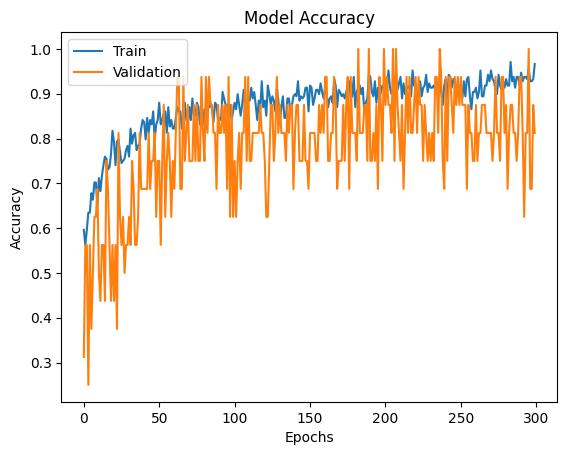

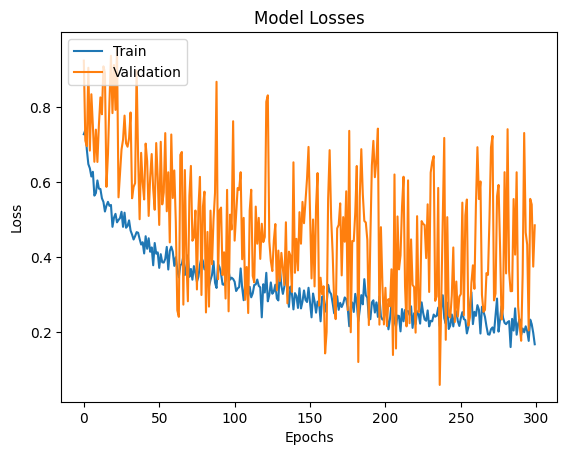

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
3/3 [==============================] - 12s 5s/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.8333    0.9091    0.8696        22
        sick     0.8824    0.7895    0.8333        19

    accuracy                         0.8537        41
   macro avg     0.8578    0.8493    0.8514        41
weighted avg     0.8560    0.8537    0.8528        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [15]:
cross_validation('DenseNet121', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 16	epoch: 300
---------------------------------------------------------------------
2_DenseNet169_sm1_bch16_lr1e-05_ep300_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 16------------
51877672/51877672 [==============================] - 0s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/300
13/13 [==============================] - 63s 635ms/step - loss: 0.8290 - accuracy: 0.5865 - val_loss: 0.7388 - val_accuracy: 0.5625
Epoch 2/300
13/13 [==============================] - 5s 351ms/step - loss: 0.7728 - accuracy: 0.5913 - val_loss: 0.7173 - val_accuracy: 0.5625
Epoch 3/300
13/13 [==============================] - 4s 325ms/step - loss: 0.7470 - accuracy: 0.6202 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/300
13/13 [=======

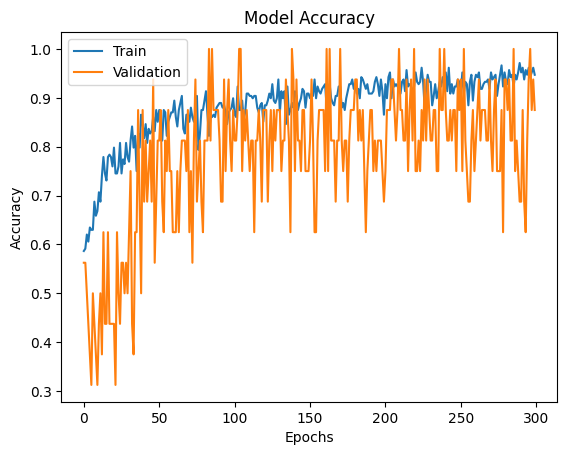

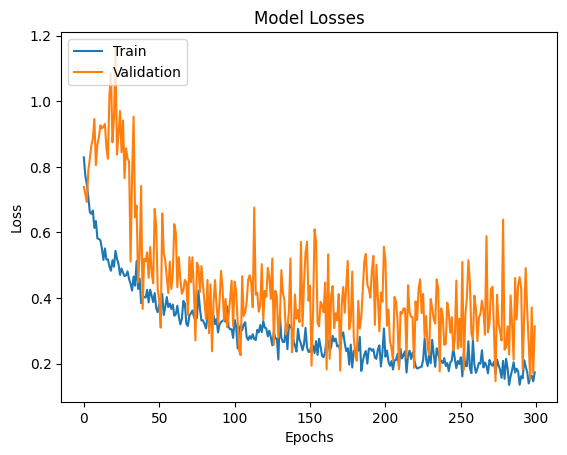

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
3/3 [==============================] - 4s 678ms/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.8696    0.9091    0.8889        22
        sick     0.8889    0.8421    0.8649        19

    accuracy                         0.8780        41
   macro avg     0.8792    0.8756    0.8769        41
weighted avg     0.8785    0.8780    0.8778        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [16]:
cross_validation('DenseNet169', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 16	epoch: 300
---------------------------------------------------------------------
2_InceptionV3_sm1_bch16_lr1e-05_ep300_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 16------------
87910968/87910968 [==============================] - 1s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/300
13/13 [==============================] - 36s 600ms/step - loss: 0.7058 - accuracy: 0.5529 - val_loss: 0.7336 - val_accuracy: 0.4375
Epoch 2/300
13/13 [==============================] - 6s 452ms/step - loss: 0.6970 - accuracy: 0.5481 - val_loss: 0.6599 - val_accuracy: 0.5625
Epoch 3/300
13/13 [==============================] - 7s 553ms/step - loss: 0.7119 - accuracy: 0.5144 - val_loss: 0.7924 - val_accuracy: 0.5000
Epoch 4/300
13/13 [=======

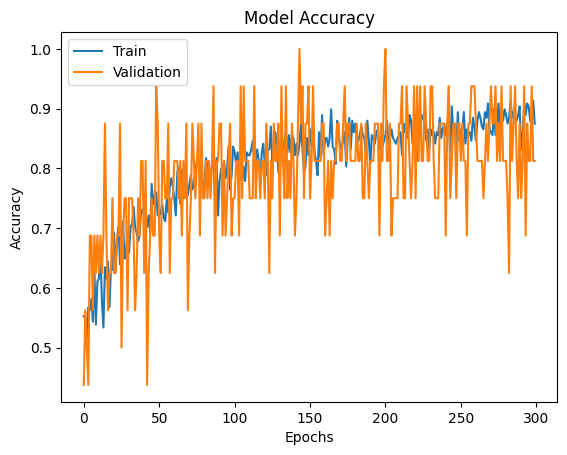

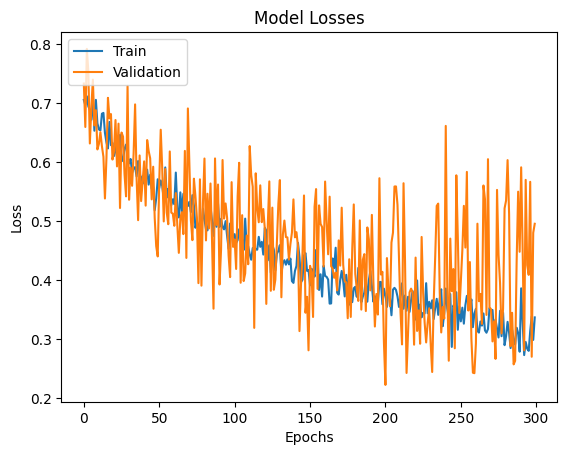

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
3/3 [==============================] - 5s 1s/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.7600    0.8636    0.8085        22
        sick     0.8125    0.6842    0.7429        19

    accuracy                         0.7805        41
   macro avg     0.7863    0.7739    0.7757        41
weighted avg     0.7843    0.7805    0.7781        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [17]:
cross_validation('InceptionV3', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 16	epoch: 300
---------------------------------------------------------------------
2_MobileNet_sm1_bch16_lr1e-05_ep300_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 16------------
17225924/17225924 [==============================] - 0s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/300
13/13 [==============================] - 12s 425ms/step - loss: 1.0723 - accuracy: 0.5673 - val_loss: 1.5773 - val_accuracy: 0.2500
Epoch 2/300
13/13 [==============================] - 3s 256ms/step - loss: 1.0079 - accuracy: 0.5673 - val_loss: 0.9525 - val_accuracy: 0.5625
Epoch 3/300
13/13 [==============================] - 4s 275ms/step - loss: 0.9990 - accuracy: 0.5721 - val_loss: 0.8457 - val_accuracy: 0.6250
Epoch 4/300
13/13 [=========

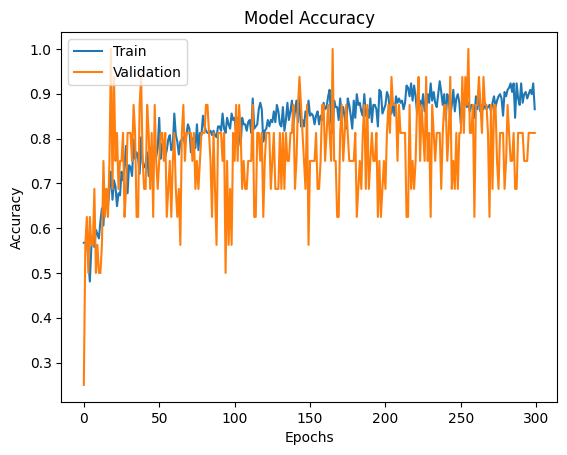

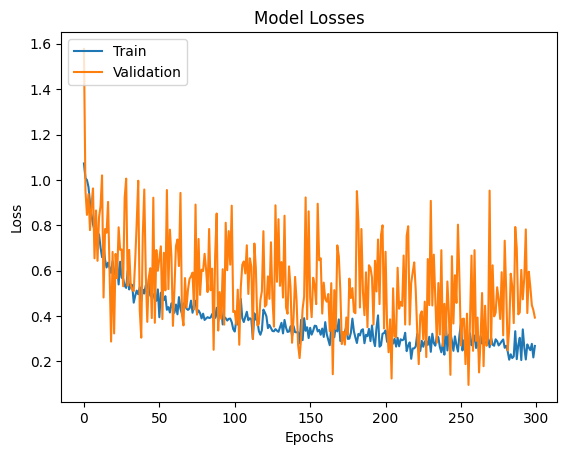

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
3/3 [==============================] - 1s 310ms/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.8095    0.7727    0.7907        22
        sick     0.7500    0.7895    0.7692        19

    accuracy                         0.7805        41
   macro avg     0.7798    0.7811    0.7800        41
weighted avg     0.7819    0.7805    0.7807        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [18]:
cross_validation('MobileNet', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 16	epoch: 300
---------------------------------------------------------------------
2_MobileNetV2_sm1_bch16_lr1e-05_ep300_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 16------------
9406464/9406464 [==============================] - 0s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/300
13/13 [==============================] - 18s 327ms/step - loss: 0.7669 - accuracy: 0.5048 - val_loss: 0.7617 - val_accuracy: 0.4375
Epoch 2/300
13/13 [==============================] - 3s 256ms/step - loss: 0.7042 - accuracy: 0.5673 - val_loss: 0.7142 - val_accuracy: 0.5625
Epoch 3/300
13/13 [==============================] - 5s 378ms/step - loss: 0.7067 - accuracy: 0.5673 - val_loss: 0.6070 - val_accuracy: 0.7500
Epoch 4/300
13/13 [=========

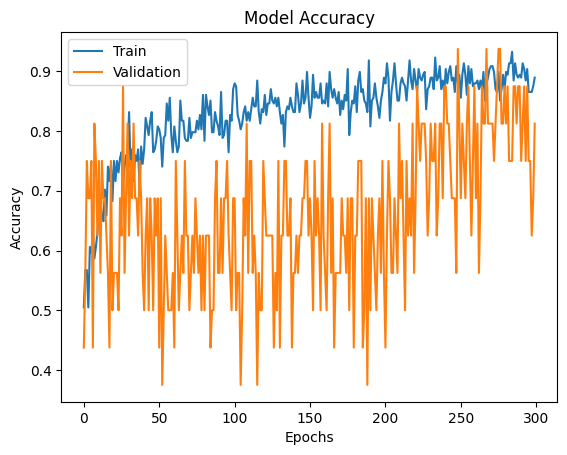

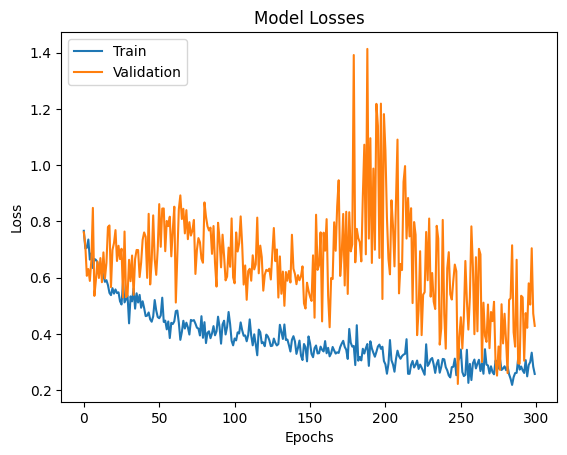

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.


3/3 [==============================] - 2s 487ms/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.8947    0.7727    0.8293        22
        sick     0.7727    0.8947    0.8293        19

    accuracy                         0.8293        41
   macro avg     0.8337    0.8337    0.8293        41
weighted avg     0.8382    0.8293    0.8293        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [19]:
cross_validation('MobileNetV2', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 16	epoch: 300
---------------------------------------------------------------------
2_NASNetMobile_sm1_bch16_lr1e-05_ep300_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 16------------
19993432/19993432 [==============================] - 0s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/300
13/13 [==============================] - 84s 638ms/step - loss: 0.7189 - accuracy: 0.5913 - val_loss: 0.6217 - val_accuracy: 0.6875
Epoch 2/300
13/13 [==============================] - 4s 340ms/step - loss: 0.7265 - accuracy: 0.5913 - val_loss: 0.6365 - val_accuracy: 0.6875
Epoch 3/300
13/13 [==============================] - 5s 366ms/step - loss: 0.7523 - accuracy: 0.5577 - val_loss: 0.7288 - val_accuracy: 0.5625
Epoch 4/300
13/13 [======

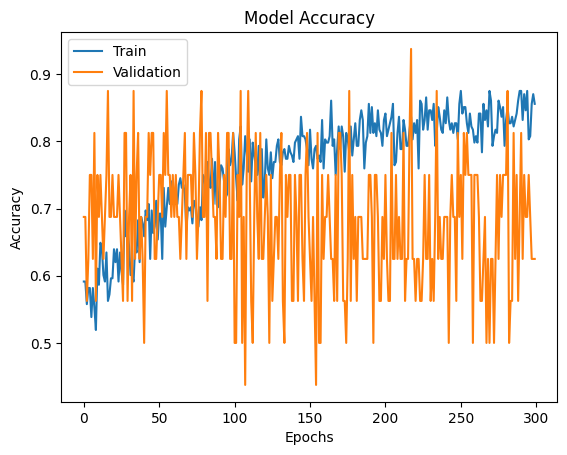

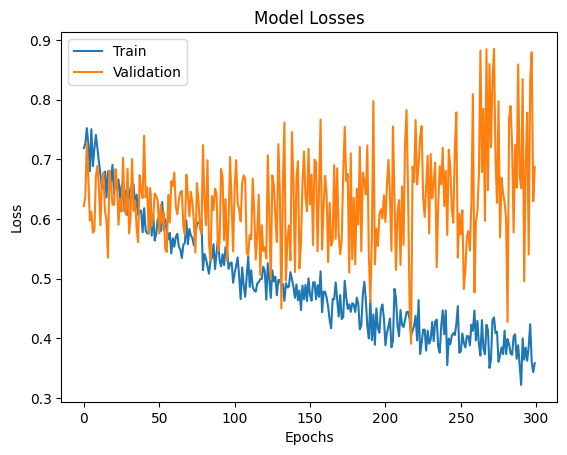

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.


3/3 [==============================] - 5s 387ms/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.7273    0.7273    0.7273        22
        sick     0.6842    0.6842    0.6842        19

    accuracy                         0.7073        41
   macro avg     0.7057    0.7057    0.7057        41
weighted avg     0.7073    0.7073    0.7073        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [20]:
cross_validation('NASNetMobile', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 16	epoch: 300
---------------------------------------------------------------------
2_ResNet101_sm1_bch16_lr1e-05_ep300_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 16------------
171446536/171446536 [==============================] - 1s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/300
13/13 [==============================] - 47s 558ms/step - loss: 0.8341 - accuracy: 0.5385 - val_loss: 0.6892 - val_accuracy: 0.6250
Epoch 2/300
13/13 [==============================] - 5s 383ms/step - loss: 0.7935 - accuracy: 0.5673 - val_loss: 0.6958 - val_accuracy: 0.4375
Epoch 3/300
13/13 [==============================] - 5s 363ms/step - loss: 0.8181 - accuracy: 0.5096 - val_loss: 1.1170 - val_accuracy: 0.5000
Epoch 4/300
13/13 [=======

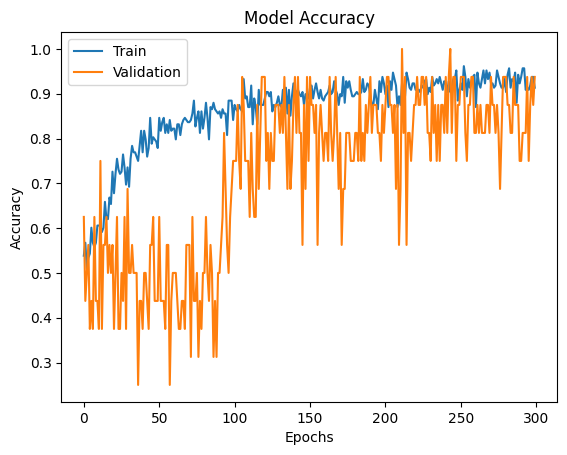

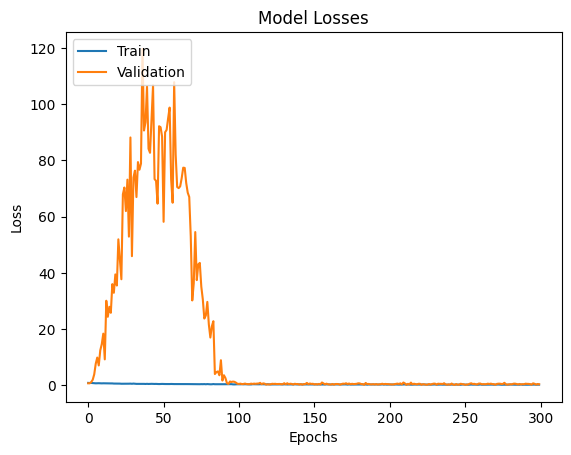

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
3/3 [==============================] - 4s 648ms/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.8333    0.9091    0.8696        22
        sick     0.8824    0.7895    0.8333        19

    accuracy                         0.8537        41
   macro avg     0.8578    0.8493    0.8514        41
weighted avg     0.8560    0.8537    0.8528        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [21]:
cross_validation('ResNet101', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 16	epoch: 300
---------------------------------------------------------------------
2_ResNet50_sm1_bch16_lr1e-05_ep300_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 16------------
94765736/94765736 [==============================] - 0s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/300
13/13 [==============================] - 21s 408ms/step - loss: 1.0231 - accuracy: 0.5913 - val_loss: 0.8520 - val_accuracy: 0.3750
Epoch 2/300
13/13 [==============================] - 5s 378ms/step - loss: 0.9430 - accuracy: 0.6058 - val_loss: 0.7286 - val_accuracy: 0.3750
Epoch 3/300
13/13 [==============================] - 4s 301ms/step - loss: 0.9358 - accuracy: 0.5721 - val_loss: 0.7070 - val_accuracy: 0.4375
Epoch 4/300
13/13 [==========

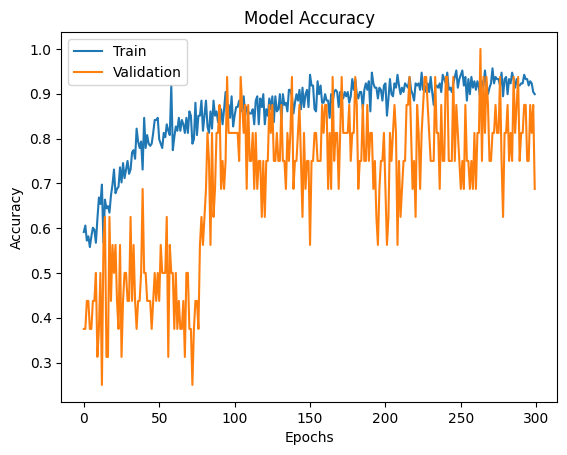

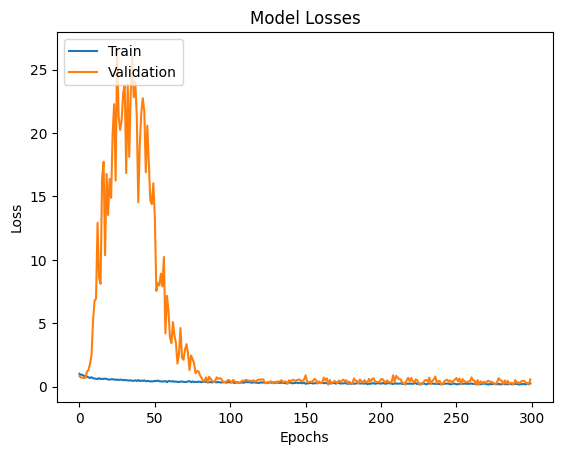

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
3/3 [==============================] - 2s 85ms/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.9444    0.7727    0.8500        22
        sick     0.7826    0.9474    0.8571        19

    accuracy                         0.8537        41
   macro avg     0.8635    0.8600    0.8536        41
weighted avg     0.8694    0.8537    0.8533        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [22]:
cross_validation('ResNet50', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 16	epoch: 300
---------------------------------------------------------------------
2_ResNet50V2_sm1_bch16_lr1e-05_ep300_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 16------------
94668760/94668760 [==============================] - 0s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/300
13/13 [==============================] - 22s 429ms/step - loss: 0.9510 - accuracy: 0.6010 - val_loss: 0.8529 - val_accuracy: 0.6250
Epoch 2/300
13/13 [==============================] - 4s 322ms/step - loss: 0.8706 - accuracy: 0.6010 - val_loss: 1.0634 - val_accuracy: 0.4375
Epoch 3/300
13/13 [==============================] - 4s 288ms/step - loss: 0.8959 - accuracy: 0.5817 - val_loss: 0.9723 - val_accuracy: 0.3750
Epoch 4/300
13/13 [========

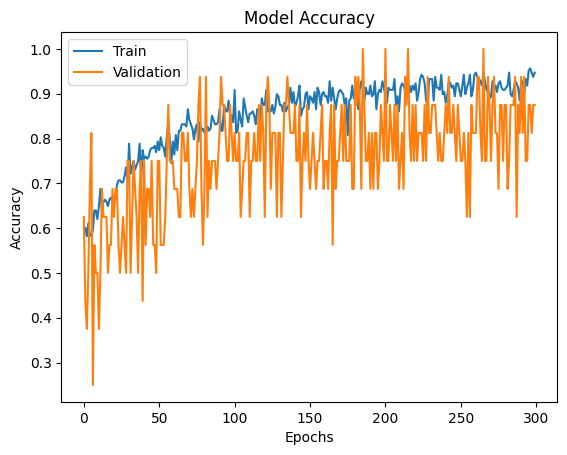

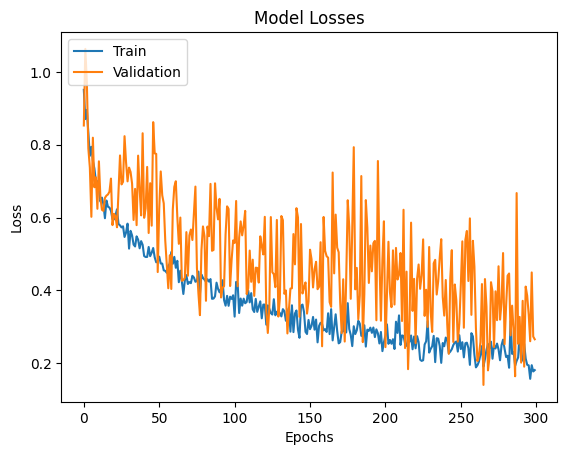

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
3/3 [==============================] - 2s 607ms/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.8095    0.7727    0.7907        22
        sick     0.7500    0.7895    0.7692        19

    accuracy                         0.7805        41
   macro avg     0.7798    0.7811    0.7800        41
weighted avg     0.7819    0.7805    0.7807        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [23]:
cross_validation('ResNet50V2', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 16	epoch: 300
---------------------------------------------------------------------
2_VGG16_sm1_bch16_lr1e-05_ep300_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 16------------
58889256/58889256 [==============================] - 0s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/300
13/13 [==============================] - 17s 311ms/step - loss: 0.8373 - accuracy: 0.4038 - val_loss: 0.7828 - val_accuracy: 0.4375
Epoch 2/300
13/13 [==============================] - 4s 309ms/step - loss: 0.7395 - accuracy: 0.4663 - val_loss: 0.7059 - val_accuracy: 0.5000
Epoch 3/300
13/13 [==============================] - 5s 408ms/step - loss: 0.7295 - accuracy: 0.3654 - val_loss: 0.6896 - val_accuracy: 0.5000
Epoch 4/300
13/13 [=============

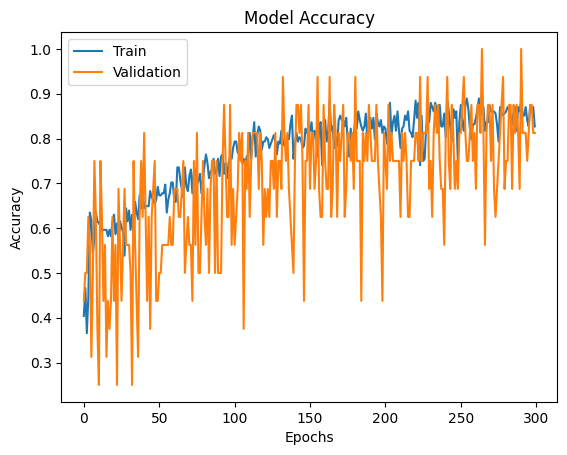

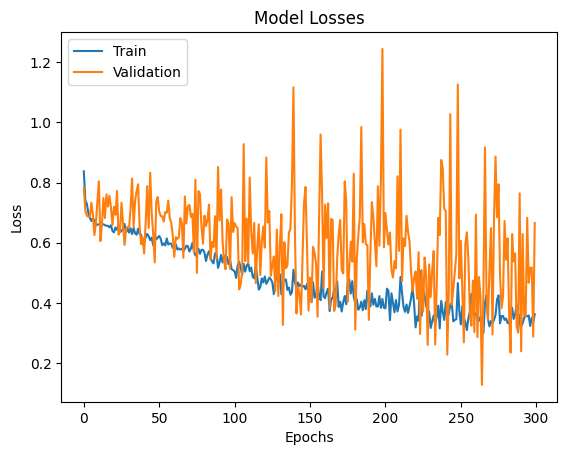

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
3/3 [==============================] - 3s 1s/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.7692    0.9091    0.8333        22
        sick     0.8667    0.6842    0.7647        19

    accuracy                         0.8049        41
   macro avg     0.8179    0.7967    0.7990        41
weighted avg     0.8144    0.8049    0.8015        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [24]:
cross_validation('VGG16', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 16	epoch: 300
---------------------------------------------------------------------
2_VGG19_sm1_bch16_lr1e-05_ep300_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 16------------
80134624/80134624 [==============================] - 0s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/300
13/13 [==============================] - 7s 332ms/step - loss: 0.6754 - accuracy: 0.6154 - val_loss: 0.6838 - val_accuracy: 0.5625
Epoch 2/300
13/13 [==============================] - 5s 417ms/step - loss: 0.6711 - accuracy: 0.6154 - val_loss: 0.7292 - val_accuracy: 0.4375
Epoch 3/300
13/13 [==============================] - 4s 324ms/step - loss: 0.6791 - accuracy: 0.5865 - val_loss: 0.6749 - val_accuracy: 0.5625
Epoch 4/300
13/13 [==============

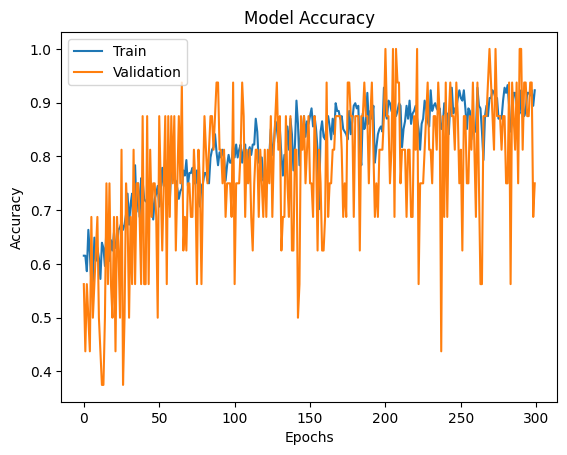

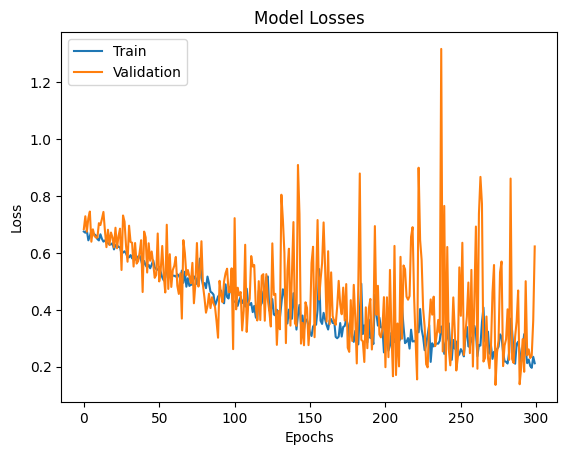

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
3/3 [==============================] - 0s 73ms/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.8824    0.6818    0.7692        22
        sick     0.7083    0.8947    0.7907        19

    accuracy                         0.7805        41
   macro avg     0.7953    0.7883    0.7800        41
weighted avg     0.8017    0.7805    0.7792        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [25]:
cross_validation('VGG19', 1)



---------------------Parametros | Hiperparametros--------------------
Recorrido: 0	Fold0	lr: 1e-05	batch: 16	epoch: 300
---------------------------------------------------------------------
2_Xception_sm1_bch16_lr1e-05_ep300_ada_Fold0_

 /content/drive/MyDrive/Colab Notebooks/DataSets/Fundus/RIM/Fold0/
------------ lr: 1e-05 - batch_size: 16------------
83683744/83683744 [==============================] - 1s 0us/step
Found 368 images belonging to 2 classes.
368
Found 46 images belonging to 2 classes.
46

Starting to Fine Tune Model

Epoch 1/300
13/13 [==============================] - 30s 602ms/step - loss: 0.6703 - accuracy: 0.6154 - val_loss: 0.6812 - val_accuracy: 0.5000
Epoch 2/300
13/13 [==============================] - 7s 527ms/step - loss: 0.6493 - accuracy: 0.6346 - val_loss: 0.7065 - val_accuracy: 0.5000
Epoch 3/300
13/13 [==============================] - 7s 529ms/step - loss: 0.6640 - accuracy: 0.5962 - val_loss: 0.7298 - val_accuracy: 0.3750
Epoch 4/300
13/13 [==========

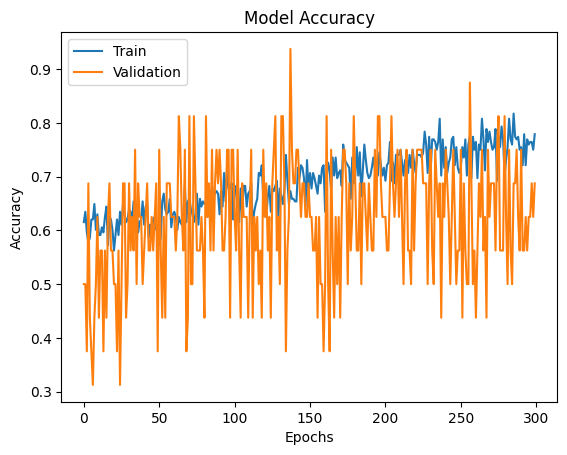

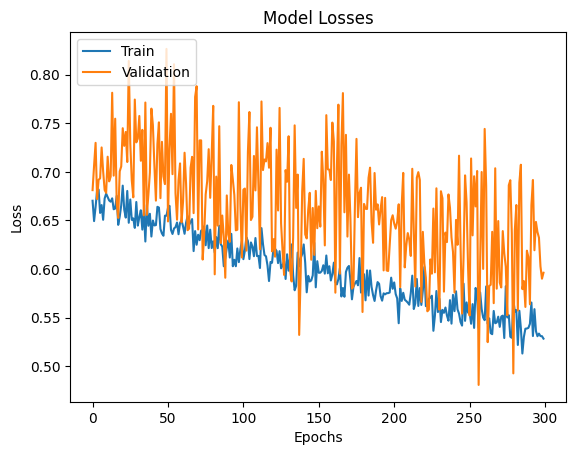

Datos entrenamiento y Gráficos guardados!!!

----------Test----------
Found 41 images belonging to 2 classes.
3/3 [==============================] - 4s 1s/step
Classification Report
              precision    recall  f1-score   support

    not_sick     0.8571    0.5455    0.6667        22
        sick     0.6296    0.8947    0.7391        19

    accuracy                         0.7073        41
   macro avg     0.7434    0.7201    0.7029        41
weighted avg     0.7517    0.7073    0.7002        41

Test.csv guardado!!!
--------------------Fin fold Fold0--------------------


In [26]:
cross_validation('Xception', 1)

In [27]:
print('Fin!!!')

Fin!!!
